Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)    │ (None, 256, 256, 1)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_90 (Conv2D)            │ (None, 256, 256, 32)      │             320 │ input_layer_4[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d_18              │ (None, 128, 128, 32)      │               0 │ conv2d_90[0][0]            │
│ (MaxPooling2D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_91 (Conv2D)            │ (None, 128, 128, 64)      │          18,496 │ max_pooling2d_18[0][0]     │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ up_sampling2d_4               │ (None, 256, 256, 64)      │               0 │ conv2d_91[0][0]            │
│ (UpSampling2D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ concatenate_18 (Concatenate)  │ (None, 256, 256, 96)      │               0 │ up_sampling2d_4[0][0],     │
│                               │                           │                 │ conv2d_90[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_92 (Conv2D)            │ (None, 256, 256, 32)      │          27,680 │ concatenate_18[0][0]       │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_93 (Conv2D)            │ (None, 256, 256, 1)       │              33 │ conv2d_92[0][0]            │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 46,529 (181.75 KB)

 Trainable params: 46,529 (181.75 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 261s 3s/step - accuracy: 0.9217 - loss: 0.3478 - val_accuracy: 0.9808 - val_loss: 0.0658
Epoch 2/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 141s 2s/step - accuracy: 0.9806 - loss: 0.0660 - val_accuracy: 0.9808 - val_loss: 0.0633
Epoch 3/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 124s 2s/step - accuracy: 0.9811 - loss: 0.0637 - val_accuracy: 0.9808 - val_loss: 0.0658
Epoch 4/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 111s 1s/step - accuracy: 0.9816 - loss: 0.0630 - val_accuracy: 0.9808 - val_loss: 0.0645
Epoch 5/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 111s 1s/step - accuracy: 0.9806 - loss: 0.0651 - val_accuracy: 0.9808 - val_loss: 0.0626
Epoch 6/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 104s 1s/step - accuracy: 0.9812 - loss: 0.0614 - val_accuracy: 0.9808 - val_loss: 0.0625
Epoch 7/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 109s 1s/step - accuracy: 0.9814 - loss: 0.0608 - val_accuracy: 0.9808 - val_loss: 0.0635
Epoch 8/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 115s 1s/step - accuracy: 0.9807 - loss: 0.0627 - val_accuracy: 0.9808 - v

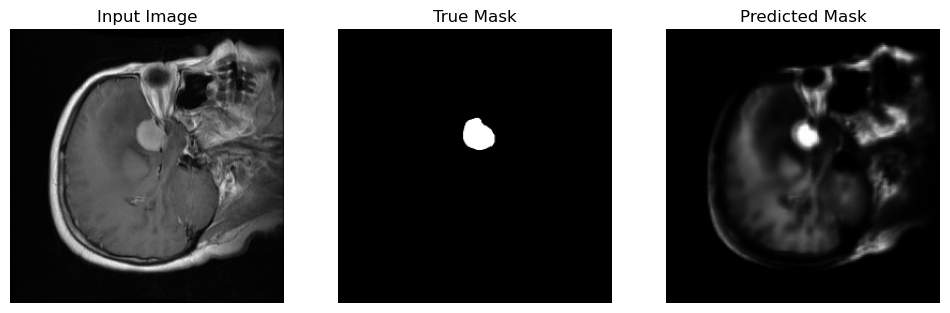

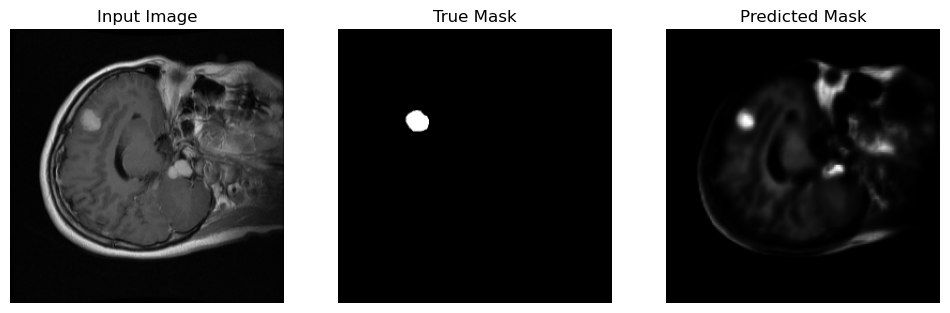

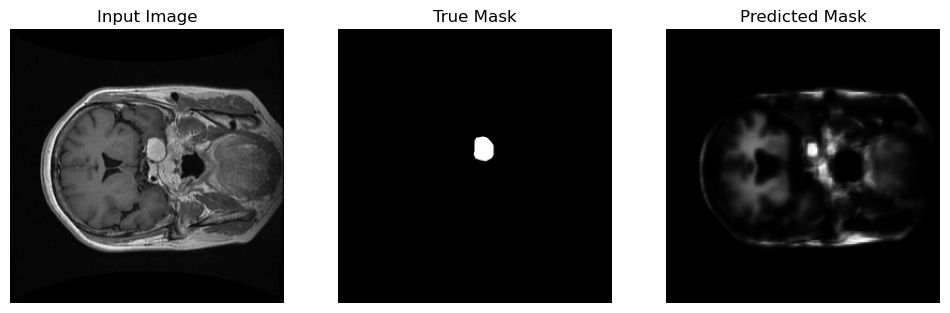

In [40]:
import os
import glob
import h5py
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate
from tensorflow.keras.models import Model

##############################################
# STEP 1: LOAD DATA FROM .mat FILES
##############################################

data_folder = "data"  # Folder containing your MAT files
mat_files = glob.glob(os.path.join(data_folder, "*.mat"))

image_data_list = []
mask_data_list = []

for file in mat_files:
    with h5py.File(file, 'r') as f:
        cjdata = f['cjdata']
        img = np.array(cjdata['image'])
        mask = np.array(cjdata['tumorMask'])
        image_data_list.append(img)
        mask_data_list.append(mask)

image_data = np.array(image_data_list)
mask_data = np.array(mask_data_list)

##############################################
# STEP 2: DATA PREPROCESSING
##############################################

def preprocess_and_resize(img, target_size=(256, 256), eps=1e-8):
    img = img.astype(np.float32)
    min_val, max_val = np.min(img), np.max(img)
    img = (img - min_val) / ((max_val - min_val) + eps)
    return cv2.resize(img, target_size)

processed_images = np.array([preprocess_and_resize(img) for img in image_data])
processed_masks  = np.array([preprocess_and_resize(msk) for msk in mask_data])

X = processed_images[..., np.newaxis]
Y = processed_masks[..., np.newaxis]

X_train, X_val, y_train, y_val = train_test_split(X, Y, test_size=0.2, random_state=42)

##############################################
# STEP 3: DEFINE THE SIMPLEST POSSIBLE U-NET
##############################################

def tiny_unet(input_size=(256, 256, 1)):
    inputs = Input(input_size)

    # **Single Encoder Block**
    c1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    p1 = MaxPooling2D((2, 2))(c1)

    # Bottleneck
    c2 = Conv2D(64, (3, 3), activation='relu', padding='same')(p1)

    # **Single Decoder Block**
    u1 = UpSampling2D((2, 2))(c2)
    u1 = concatenate([u1, c1])
    c3 = Conv2D(32, (3, 3), activation='relu', padding='same')(u1)

    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c3)

    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

model = tiny_unet(input_size=(256, 256, 1))
model.summary()

##############################################
# STEP 4: TRAIN THE MODEL
##############################################

batch_size = 8
epochs = 20

history = model.fit(
    X_train, y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(X_val, y_val)
)

##############################################
# STEP 5: VISUALIZE PREDICTIONS
##############################################

predictions = model.predict(X_val)
num_examples = 3
for i in range(num_examples):
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 3, 1)
    plt.imshow(X_val[i].squeeze(), cmap='gray')
    plt.title("Input Image")
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(y_val[i].squeeze(), cmap='gray')
    plt.title("True Mask")
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(predictions[i].squeeze(), cmap='gray')
    plt.title("Predicted Mask")
    plt.axis('off')

    plt.show()
